# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world.

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!


# Import libraries

In [61]:
# # libraries
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np
from functools import partial


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Attention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import Loss
from tensorflow.keras import regularizers
from tensorflow.keras.utils import register_keras_serializable




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import urllib.request


import joblib
from joblib import Parallel, delayed
import pickle

# Download NLTK resources
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

#pandas configuration
pd.set_option('display.max_columns', None)
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set random seed
np.random.seed(seed=42)

In [64]:
PATH = f"/content/drive/MyDrive/00. Etsy Machine Learning Challenge/Data/data_2025/"
# parquet_filenames_train = !ls "{PATH}/train"
# parquet_filenames_train = parquet_filenames_train[0].split()

# parquet_filenames_test = !ls "{PATH}/test"
# parquet_filenames_test = parquet_filenames_test[0].split()
train_path = os.path.join(PATH, "train")
parquet_filenames_train = os.listdir(train_path)

test_path = os.path.join(PATH, "test")
parquet_filenames_test = os.listdir(test_path)

# Solution Begins here

## Define Functions

In [68]:
# Compile regex patterns once for efficiency
PATTERN_APOSTROPHE = re.compile(r"&#39;")
PATTERN_AMP = re.compile(r'amp;')
PATTERN_URL = re.compile(r'http\S+|www\.\S+')
PATTERN_DOTS = re.compile(r'\.{2,}')
PATTERN_WHITESPACE = re.compile(r'\s+')


def read_data(folder: str, filenames: list[str]) -> pd.DataFrame:
    """
    Reads the parquet file from the specified directory.

    Parameters:
    -----------
    folder : str
        Path to the folder containing the parquet file.
    filenames : list(str)
         list of parquet files to read.

    Returns:
    --------
    pd.DataFrame
        Loaded DataFrame from the parquet file.
    """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames
    ]

    return pd.concat(dataframes).reset_index(drop=True)

def clean_text_vectorized(text_series: pd.Series) -> pd.Series:
    """
    Clean a Pandas Series of text data using common preprocessing steps.

    Parameters:
    -----------
    text_series : pd.Series
        Input text data to be cleaned.

    Returns:
    --------
    pd.Series
        Cleaned text data.
    """
    # Handle NaN by replacing with empty string
    text_series = text_series.fillna('')

    # Convert to string and lowercase (vectorized)
    text_series = text_series.astype(str).str.lower()

    # Apply regex replacements (vectorized)
    text_series = text_series.str.replace(PATTERN_APOSTROPHE, "'", regex=True)
    text_series = text_series.str.replace(PATTERN_AMP, '&', regex=True)
    text_series = text_series.str.replace(r'\\n|\n', ' ', regex=True)
    text_series = text_series.str.replace(PATTERN_URL, '', regex=True)
    text_series = text_series.str.replace(PATTERN_DOTS, ' ', regex=True)
    text_series = text_series.str.replace(PATTERN_WHITESPACE, ' ', regex=True)


    return text_series.str.strip()


def preprocess_data(
    data: pd.DataFrame,
    feature_cols: list[str],
    text_cols: list[str],
    metadata_cols: list[str],
    dataset_type: str ='train'
) -> pd.DataFrame:
    """
    Preprocess dataset by removing duplicates and combining text columns.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset.
    feature_cols : List[str]
        Columns to consider for duplicate detection.
    text_cols : List[str]
        Columns containing the main text features.
    metadata_cols : List[str]
        Metadata columns to be combined into text.

    Returns:
    --------
    pd.DataFrame
        Preprocessed DataFrame with combined and cleaned text.
    """
    print("Preparing features...")
    # drop duplicates
    df = data.copy()
    if dataset_type=='train':
      print('\n Dropping duplicates in train data')
      print("=== Rows in raw df ===",df.shape)
      print("=== Duplicates in df === ",df.duplicated(subset=feature_columns).sum())
      df = df.drop_duplicates(subset=feature_columns).reset_index(drop=True)
      print("=== Rows after dropping duplicates ===",df.shape)
      print("=== Duplicates in df === ",df.duplicated(subset=feature_columns).sum())
    else:
      print("\n Ignoring duplicate values in test")

    # Combine textual features
    df['metadata_combined_text'] = df[metadata_columns].fillna('unknown').agg(' '.join, axis=1)
    df['combined_text'] = df[text_columns].fillna('unknown').agg(' '.join, axis=1)
    df['combined_text'] = df['combined_text'] + ' ' + df['metadata_combined_text']
    df['combined_text'] = clean_text_vectorized(df['combined_text'])

    return df


def encode_labels(df: pd.DataFrame) -> tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
    """
    Encode 'top_category_text' and 'bottom_category_text' into numeric labels.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing category columns.

    Returns:
    --------
    Tuple[pd.DataFrame, LabelEncoder, LabelEncoder]
        Updated DataFrame and the encoders for top and bottom categories.
    """
    print("Encoding labels...")
    top_encoder = LabelEncoder()
    bottom_encoder = LabelEncoder()

    df['top_category_encoded'] = top_encoder.fit_transform(df['top_category_text'])
    df['bottom_category_encoded'] = bottom_encoder.fit_transform(df['bottom_category_text'])

    return df, top_encoder, bottom_encoder


def tokenize_text(texts: list[str],
    max_words: int = 50000,
    max_len: int = 300
) -> tuple[np.ndarray, Tokenizer]:
    """
    Tokenize and pad sequences from input text.

    Parameters:
    -----------
    texts : List[str]
        List of text samples to tokenize.
    max_words : int
        Maximum number of words to keep in the vocabulary.
    max_len : int
        Maximum length of sequences after padding.

    Returns:
    --------
    Tuple[np.ndarray, Tokenizer]
        Padded sequences and the fitted Tokenizer.
    """
    print("Tokenizing texts...")
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    return padded_sequences, tokenizer


def load_glove_embeddings(word_index: dict, embedding_dim: int = 200) -> np.ndarray:
    """
    Load GloVe embeddings and create an embedding matrix.

    Parameters:
    -----------
    word_index : Dict[str, int]
        Mapping from words to their index in the tokenizer.
    embedding_dim : int
        Dimension of the GloVe embeddings to load.

    Returns:
    --------
    np.ndarray
        Embedding matrix with pretrained GloVe vectors.
    """

    print(f"Loading GloVe embeddings (dimension: {embedding_dim})...")

    # Download GloVe embeddings if not already present
    glove_path = f'glove.6B.{embedding_dim}d.txt'
    if not os.path.isfile(glove_path):
        print(f"Downloading GloVe embeddings...")
        url = f'https://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(url, 'glove.6B.zip')
        import zipfile
        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Download complete.")

    # Load embeddings - optimized memory usage with generators
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:  # Only store needed embeddings
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors for vocabulary.")

    # Create embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


def feature_vectorize(X_train: list[str],
    X_val: list[str],
    X_test: list[str],
    y_train: np.ndarray,
    y_val: np.ndarray,
    y_test: np.ndarray
) -> str:
    """
    TF-IDF vectorization for text features.

    Parameters:
    -----------
    X_train, X_val, X_test : List[str]
        Text data for training, validation, and testing.
    y_train, y_val, y_test : np.ndarray
        Corresponding labels.

    Returns:
    --------
    Tuple of vectorized sets and target arrays
    """

    print("\nPerforming TFIDF Vectorization...")
    tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

    X_train_vec = tfidf.fit_transform(X_train)
    X_val_vec = tfidf.transform(X_val)
    X_test_vec = tfidf.transform(X_test)

    return X_train_vec, X_val_vec, X_test_vec, y_train, y_val, y_test, tfidf



def train_logistic_regression(X_train,
    y_train: np.ndarray
) -> LogisticRegression:
    """
    Train a multinomial logistic regression classifier.

    Parameters:
    -----------
    X_train : Any
        Vectorized feature input.
    y_train : np.ndarray
        Target labels.

    Returns:
    --------
    LogisticRegression
        Trained model.
    """
    print("Fitting Logistic Regression model...")

    model = LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        solver='saga',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    return model


# Multi-class focal loss (TensorFlow)
@register_keras_serializable()
class SparseCategoricalFocalLoss(Loss):
    """
    Custom sparse categorical focal loss for handling class imbalance.

    Parameters:
    -----------
    gamma : float
        Focusing parameter for modulating factor (1-p).
    alpha : float
        Balancing factor for positive/negative samples.
    """
    def __init__(self, gamma=2.0, alpha=0.25, name="sparse_focal_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
        p_t = tf.exp(-ce)
        loss = self.alpha * tf.pow(1 - p_t, self.gamma) * ce
        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            'gamma': self.gamma,
            'alpha': self.alpha
        })
        return config

# Build Enhanced RNN Model with Metadata Integration and Pretrained Embeddings
def build_enhanced_rnn_model(vocab_size: int,
    max_len: int,
    embedding_dim: int,
    num_top_categories: int,
    num_bottom_categories: int,
    embedding_matrix: np.ndarray
) -> tf.keras.Model:
    """
    Build an enhanced BiLSTM model with GloVe embeddings and dual output heads for hierarchical classification.

    Parameters:
    -----------
    vocab_size : int
        Size of the vocabulary from tokenizer.
    max_len : int
        Maximum sequence length for inputs.
    embedding_dim : int
        Dimension of word embeddings.
    num_top_categories : int
        Number of classes in the top category.
    num_bottom_categories : int
        Number of classes in the bottom category.
    embedding_matrix : np.ndarray
        Pretrained embedding matrix from GloVe.

    Returns:
    --------
    tf.keras.Model
        Compiled Keras model ready for training.
    """

    print("Building BiDirectional LSTM  model...")

    # Text Input layer
    text_input = Input(shape=(max_len,), name='text_input')

    ##Use pre-trained GloVe embeddings for text
    text_embedding = Embedding(
        input_dim=len(embedding_matrix),
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False,  # Freeze the embeddings
        name='text_embedding'
    )(text_input)


    # Bidirectional LSTM layers for text
    text_lstm1 = Bidirectional(LSTM(128, return_sequences=True),name='bilstm1')(text_embedding)
    text_lstm1 = LayerNormalization(name='ln1')(text_lstm1)

    # Self-attention mechanism
    attention = Attention(name='self_attn')([text_lstm1, text_lstm1])

    # Combine attention with LSTM output
    context = Concatenate(name='context')([text_lstm1, attention])

    # # Global Max Pooling after `context`
    max_pooled = GlobalMaxPooling1D(name='max_pool')(context)
    avg_pooled = GlobalAveragePooling1D(name='avg_pool')(context)
    text_features = Concatenate(name='feat_concat')([max_pooled, avg_pooled])
    text_features = Dropout(0.3,name='feat_dropout')(text_features)


    # Top category prediction branch
    top_dense = Dense(256, activation='relu')(text_features)
    top_dense = Dropout(0.3)(top_dense)
    top_output = Dense(top_categories, activation='softmax', name='top_category')(top_dense)

    # Bottom category prediction branch
    bottom_dense = Dense(512,activation='relu')(text_features)
    bottom_dense = Dropout(0.4)(bottom_dense)
    bottom_output = Dense(bottom_categories, activation='softmax', name='bottom_category')(bottom_dense)

    model = Model(inputs=text_input, outputs=[top_output, bottom_output])


    # instantiate focal‑loss objects
    focal_top    = SparseCategoricalFocalLoss(gamma=2.0, alpha=0.25, name='focal_top')
    focal_bottom = SparseCategoricalFocalLoss(gamma=2.0, alpha=0.25, name='focal_bottom')

    # Compile the model
    model.compile(
        optimizer='adam',
        loss={
            'top_category': focal_top,
            'bottom_category': focal_bottom
        },
        loss_weights={'top_category': 0.7, 'bottom_category': 1.3},
        metrics={
            'top_category': 'accuracy',
            'bottom_category': 'accuracy'
        }
    )

    return model

# Training and Evaluation Functions
def train_model(model: tf.keras.Model,
    X_train: dict[str, np.ndarray],
    y_train_top: np.ndarray,
    y_train_bottom: np.ndarray,
    X_val: dict[str, np.ndarray],
    y_val_top: np.ndarray,
    y_val_bottom: np.ndarray,
    batch_size: int = 64,
    epochs: int = 10
) -> tuple[tf.keras.Model, tf.keras.callbacks.History]:
    """
    Train the RNN model with early stopping and model checkpointing.

    Parameters:
    -----------
    model : tf.keras.Model
        Compiled model to train.
    X_train : Dict[str, np.ndarray]
        Input features for training.
    y_train_top : np.ndarray
        Labels for top category.
    y_train_bottom : np.ndarray
        Labels for bottom category.
    X_val : Dict[str, np.ndarray]
        Input features for validation.
    y_val_top : np.ndarray
        Validation labels for top category.
    y_val_bottom : np.ndarray
        Validation labels for bottom category.
    batch_size : int
        Number of samples per training batch.
    epochs : int
        Total training epochs.

    Returns:
    --------
    Tuple[tf.keras.Model, History]
        Trained model and training history.
    """

    print("Training model...")

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    reduce_bot = ReduceLROnPlateau(
    monitor='val_bottom_category_loss', factor=0.5,
    patience=3, min_lr=1e-6, verbose=1
)

    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )


    # Train the model
    history = model.fit(
        X_train,
        {'top_category': y_train_top, 'bottom_category': y_train_bottom},
        validation_data=(X_val, {'top_category': y_val_top, 'bottom_category': y_val_bottom}),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, reduce_bot,model_checkpoint],

    )

    return model, history

def evaluate_model(model: tf.keras.Model,
    X_test: dict[str, np.ndarray],
    y_test_top: np.ndarray,
    y_test_bottom: np.ndarray,
    top_encoder: LabelEncoder,
    bottom_encoder: LabelEncoder
) -> tuple[float, float]:
    """
    Evaluate the trained model and visualize F1 scores.

    Parameters:
    -----------
    model : tf.keras.Model
        Trained model to evaluate.
    X_test : Dict[str, np.ndarray]
        Test input features.
    y_test_top : np.ndarray
        True labels for top category.
    y_test_bottom : np.ndarray
        True labels for bottom category.
    top_encoder : LabelEncoder
        Fitted encoder for top category.
    bottom_encoder : LabelEncoder
        Fitted encoder for bottom category.

    Returns:
    --------
    Tuple[float, float]
        Macro F1 scores for top and bottom categories.
    """

    print("Evaluating model...")

    # Make predictions
    top_pred, bottom_pred = model.predict(X_test)

    # Convert predictions to class indices
    top_pred_classes = np.argmax(top_pred, axis=1)
    bottom_pred_classes = np.argmax(bottom_pred, axis=1)

    # Calculate macro F1 scores
    top_f1 = f1_score(y_test_top, top_pred_classes, average='macro')
    bottom_f1 = f1_score(y_test_bottom, bottom_pred_classes, average='macro')

    print(f"Top Category Macro F1 Score: {top_f1:.4f}")
    print(f"Bottom Category Macro F1 Score: {bottom_f1:.4f}")

    # Print classification reports
    print("\nTop Category Classification Report:")
    print(classification_report(y_test_top, top_pred_classes))

    print("\nBottom Category Classification Report:")
    print(classification_report(y_test_bottom, bottom_pred_classes))

    return top_f1, bottom_f1

In [71]:
# train_raw_df = read_data("train", parquet_filenames_train)
# train_raw_df

# Training Pipeline

In [ ]:
# Required columns for training
required_columns = [
    'product_id', 'title', 'description', 'tags', 'type', 'room',
    'craft_type', 'recipient', 'material', 'occasion', 'holiday',
    'art_subject', 'style', 'shape', 'pattern', 'bottom_category_id',
    'bottom_category_text', 'top_category_id', 'top_category_text'
]

# Define which columns are textual and which are metadata
text_columns = ['title', 'description', 'tags']
metadata_columns = [
    'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday',
    'art_subject', 'style', 'shape', 'pattern'
]

# Combined feature columns
feature_columns = text_columns + metadata_columns

# Set tokenization and embedding parameters
max_words = 50000
max_len = 300
embedding_dim = 200  # GloVe dimension

# Load raw training and test data
train_raw_df = read_data("train", parquet_filenames_train)

# Keep only the required training columns
train_df = train_raw_df[required_columns].copy()
print("Train shape:", train_df.shape)

# Preprocess the text and metadata features
processed_data = preprocess_data(train_df, feature_columns, text_columns, metadata_columns)

# Encode the top and bottom category labels
processed_data, top_encoder, bottom_encoder = encode_labels(processed_data)

# Extract target and feature columns
X_text = processed_data['combined_text']
y_top = processed_data['top_category_encoded']
y_bottom = processed_data['bottom_category_encoded']

# Split into train, validation, and test using stratified sampling
X_train_idx, X_temp_idx, y_train_top, y_temp_top, y_train_bottom, y_temp_bottom = train_test_split(
    np.arange(len(X_text)), y_top, y_bottom, test_size=0.3, stratify=y_top, random_state=42
)

X_val_idx, X_test_idx, y_val_top, y_test_top, y_val_bottom, y_test_bottom = train_test_split(
    X_temp_idx, y_temp_top, y_temp_bottom, test_size=0.5, stratify=y_temp_top, random_state=42
)

# Retrieve corresponding text samples
X_train_text = X_text.iloc[X_train_idx].reset_index(drop=True)
X_val_text = X_text.iloc[X_val_idx].reset_index(drop=True)
X_test_text = X_text.iloc[X_test_idx].reset_index(drop=True)


Train shape: (229624, 19)
Preparing features...

 Dropping duplicates in train data
=== Rows in raw df === (229624, 19)
=== Duplicates in df ===  2186
=== Rows after dropping duplicates === (227438, 19)
=== Duplicates in df ===  0
Encoding labels...


## Train and evaluate Logistic Regression on Top Categories

In [ ]:
# TF-IDF vectorization for traditional ML models
X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_top, y_val_top, y_test_top, tfidf_vectorizer = feature_vectorize(
    X_train_text, X_val_text, X_test_text, y_train_top, y_val_top, y_test_top
)

# Train logistic regression model
model_logistic = train_logistic_regression(X_train_tfidf, y_train_top)

# Evaluate performance on train set
y_train_pred = model_logistic.predict(X_train_tfidf)
train_f1 = f1_score(y_train_top, y_train_pred, average='macro')
print(f"Train Macro F1: {train_f1:.4f}")

# Evaluate performance on validation set
y_val_pred = model_logistic.predict(X_val_tfidf)
val_f1 = f1_score(y_val_top, y_val_pred, average='macro')
print(f"Validation Macro F1: {val_f1:.4f}")

# Evaluate performance on test set
y_test_pred = model_logistic.predict(X_test_tfidf)
test_f1 = f1_score(y_test_top, y_test_pred, average='macro')
print(f"Test Macro F1: {test_f1:.4f}")


Performing TFIDF Vectorization...
Fitting Logistic Regression model...
Train Macro F1: 0.8661
Validation Macro F1: 0.8324
Test Macro F1: 0.8290


## Prepare data for RNN Model and load Glove embedding

In [ ]:
# Tokenize and pad the text for deep learning models
X_train_padded, tokenizer = tokenize_text(X_train_text, max_words=max_words, max_len=max_len)

# Load GloVe embeddings
embedding_matrix = load_glove_embeddings(tokenizer.word_index, embedding_dim=embedding_dim)

# Pad validation and test text data
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=max_len, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_len, padding='post')

# Determine number of output classes
top_categories = len(top_encoder.classes_)
bottom_categories = len(bottom_encoder.classes_)

Tokenizing texts...
Loading GloVe embeddings (dimension: 200)...
Found 85093 word vectors for vocabulary.


## Train The Final - BiLSTM with Attention RNN Model

Building BiDirectional LSTM  model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 300, 200)  │ 55,077,400 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm1             │ (None, 300, 256)  │    336,896 │ text_embedding[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1                 │ (None, 300, 256)  │        512 │ bilstm1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attn           │ (None, 300, 256)  │          0 │ ln1[0][0],        │
│ (Attention)         │                   │            │ ln1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context             │ (None, 300, 512)  │          0 │ ln1[0][0],        │
│ (Concatenate)       │                   │            │ self_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool            │ (None, 512)       │          0 │ context[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 512)       │          0 │ context[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_concat         │ (None, 1024)      │          0 │ max_pool[0][0],   │
│ (Concatenate)       │                   │            │ avg_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_dropout        │ (None, 1024)      │          0 │ feat_concat[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    262,400 │ feat_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ feat_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ top_category        │ (None, 15)        │      3,855 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottom_category     │ (None, 2609)      │  1,338,417 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,544,280 (219.51 MB)

 Trainable params: 2,466,880 (9.41 MB)

 Non-trainable params: 55,077,400 (210.10 MB)

Training model...
Epoch 1/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.0033 - bottom_category_loss: 1.8692 - loss: 2.6276 - top_category_accuracy: 0.5459 - top_category_loss: 0.2824

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - bottom_category_accuracy: 0.0033 - bottom_category_loss: 1.8689 - loss: 2.6271 - top_category_accuracy: 0.5461 - top_category_loss: 0.2822 - val_bottom_category_accuracy: 0.0801 - val_bottom_category_loss: 1.2641 - val_loss: 1.7067 - val_top_category_accuracy: 0.7958 - val_top_category_loss: 0.0905 - learning_rate: 0.0010
Epoch 2/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.0409 - bottom_category_loss: 1.3586 - loss: 1.8378 - top_category_accuracy: 0.7814 - top_category_loss: 0.1022

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.0409 - bottom_category_loss: 1.3585 - loss: 1.8376 - top_category_accuracy: 0.7814 - top_category_loss: 0.1022 - val_bottom_category_accuracy: 0.2095 - val_bottom_category_loss: 0.9087 - val_loss: 1.2325 - val_top_category_accuracy: 0.8278 - val_top_category_loss: 0.0730 - learning_rate: 0.0010
Epoch 3/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.1011 - bottom_category_loss: 1.1146 - loss: 1.5063 - top_category_accuracy: 0.8109 - top_category_loss: 0.0819

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.1012 - bottom_category_loss: 1.1146 - loss: 1.5063 - top_category_accuracy: 0.8109 - top_category_loss: 0.0819 - val_bottom_category_accuracy: 0.3025 - val_bottom_category_loss: 0.7349 - val_loss: 1.0007 - val_top_category_accuracy: 0.8411 - val_top_category_loss: 0.0647 - learning_rate: 0.0010
Epoch 4/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.1696 - bottom_category_loss: 0.9426 - loss: 1.2759 - top_category_accuracy: 0.8267 - top_category_loss: 0.0722

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.1696 - bottom_category_loss: 0.9425 - loss: 1.2758 - top_category_accuracy: 0.8267 - top_category_loss: 0.0722 - val_bottom_category_accuracy: 0.3699 - val_bottom_category_loss: 0.6195 - val_loss: 0.8472 - val_top_category_accuracy: 0.8528 - val_top_category_loss: 0.0599 - learning_rate: 0.0010
Epoch 5/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.2368 - bottom_category_loss: 0.8045 - loss: 1.0920 - top_category_accuracy: 0.8374 - top_category_loss: 0.0659

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.2368 - bottom_category_loss: 0.8045 - loss: 1.0920 - top_category_accuracy: 0.8374 - top_category_loss: 0.0659 - val_bottom_category_accuracy: 0.4193 - val_bottom_category_loss: 0.5420 - val_loss: 0.7434 - val_top_category_accuracy: 0.8597 - val_top_category_loss: 0.0557 - learning_rate: 0.0010
Epoch 6/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.2949 - bottom_category_loss: 0.7038 - loss: 0.9574 - top_category_accuracy: 0.8454 - top_category_loss: 0.0607

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.2949 - bottom_category_loss: 0.7038 - loss: 0.9574 - top_category_accuracy: 0.8454 - top_category_loss: 0.0607 - val_bottom_category_accuracy: 0.4475 - val_bottom_category_loss: 0.5033 - val_loss: 0.6920 - val_top_category_accuracy: 0.8641 - val_top_category_loss: 0.0542 - learning_rate: 0.0010
Epoch 7/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.3316 - bottom_category_loss: 0.6363 - loss: 0.8673 - top_category_accuracy: 0.8533 - top_category_loss: 0.0572

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.3316 - bottom_category_loss: 0.6363 - loss: 0.8673 - top_category_accuracy: 0.8533 - top_category_loss: 0.0572 - val_bottom_category_accuracy: 0.4654 - val_bottom_category_loss: 0.4777 - val_loss: 0.6568 - val_top_category_accuracy: 0.8697 - val_top_category_loss: 0.0514 - learning_rate: 0.0010
Epoch 8/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.3630 - bottom_category_loss: 0.5900 - loss: 0.8051 - top_category_accuracy: 0.8571 - top_category_loss: 0.0545

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.3630 - bottom_category_loss: 0.5899 - loss: 0.8051 - top_category_accuracy: 0.8571 - top_category_loss: 0.0545 - val_bottom_category_accuracy: 0.4831 - val_bottom_category_loss: 0.4547 - val_loss: 0.6265 - val_top_category_accuracy: 0.8679 - val_top_category_loss: 0.0510 - learning_rate: 0.0010
Epoch 9/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.3873 - bottom_category_loss: 0.5488 - loss: 0.7494 - top_category_accuracy: 0.8627 - top_category_loss: 0.0514

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.3873 - bottom_category_loss: 0.5488 - loss: 0.7495 - top_category_accuracy: 0.8627 - top_category_loss: 0.0514 - val_bottom_category_accuracy: 0.4955 - val_bottom_category_loss: 0.4413 - val_loss: 0.6092 - val_top_category_accuracy: 0.8721 - val_top_category_loss: 0.0511 - learning_rate: 0.0010
Epoch 10/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4136 - bottom_category_loss: 0.5157 - loss: 0.7052 - top_category_accuracy: 0.8667 - top_category_loss: 0.0497

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4135 - bottom_category_loss: 0.5157 - loss: 0.7053 - top_category_accuracy: 0.8667 - top_category_loss: 0.0497 - val_bottom_category_accuracy: 0.5052 - val_bottom_category_loss: 0.4288 - val_loss: 0.5908 - val_top_category_accuracy: 0.8769 - val_top_category_loss: 0.0481 - learning_rate: 0.0010
Epoch 11/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4278 - bottom_category_loss: 0.4901 - loss: 0.6710 - top_category_accuracy: 0.8680 - top_category_loss: 0.0483

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4278 - bottom_category_loss: 0.4901 - loss: 0.6710 - top_category_accuracy: 0.8680 - top_category_loss: 0.0483 - val_bottom_category_accuracy: 0.5157 - val_bottom_category_loss: 0.4188 - val_loss: 0.5779 - val_top_category_accuracy: 0.8776 - val_top_category_loss: 0.0481 - learning_rate: 0.0010
Epoch 12/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4472 - bottom_category_loss: 0.4663 - loss: 0.6379 - top_category_accuracy: 0.8762 - top_category_loss: 0.0452

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - bottom_category_accuracy: 0.4472 - bottom_category_loss: 0.4663 - loss: 0.6379 - top_category_accuracy: 0.8762 - top_category_loss: 0.0452 - val_bottom_category_accuracy: 0.5245 - val_bottom_category_loss: 0.4124 - val_loss: 0.5690 - val_top_category_accuracy: 0.8808 - val_top_category_loss: 0.0473 - learning_rate: 0.0010
Epoch 13/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4569 - bottom_category_loss: 0.4473 - loss: 0.6123 - top_category_accuracy: 0.8763 - top_category_loss: 0.0439

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4569 - bottom_category_loss: 0.4473 - loss: 0.6123 - top_category_accuracy: 0.8763 - top_category_loss: 0.0439 - val_bottom_category_accuracy: 0.5313 - val_bottom_category_loss: 0.4059 - val_loss: 0.5603 - val_top_category_accuracy: 0.8803 - val_top_category_loss: 0.0471 - learning_rate: 0.0010
Epoch 14/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4743 - bottom_category_loss: 0.4306 - loss: 0.5898 - top_category_accuracy: 0.8785 - top_category_loss: 0.0430

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4743 - bottom_category_loss: 0.4306 - loss: 0.5898 - top_category_accuracy: 0.8785 - top_category_loss: 0.0430 - val_bottom_category_accuracy: 0.5352 - val_bottom_category_loss: 0.3981 - val_loss: 0.5507 - val_top_category_accuracy: 0.8805 - val_top_category_loss: 0.0477 - learning_rate: 0.0010
Epoch 15/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4843 - bottom_category_loss: 0.4148 - loss: 0.5683 - top_category_accuracy: 0.8812 - top_category_loss: 0.0415

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4843 - bottom_category_loss: 0.4148 - loss: 0.5683 - top_category_accuracy: 0.8812 - top_category_loss: 0.0415 - val_bottom_category_accuracy: 0.5458 - val_bottom_category_loss: 0.3943 - val_loss: 0.5449 - val_top_category_accuracy: 0.8816 - val_top_category_loss: 0.0464 - learning_rate: 0.0010
Epoch 16/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.4980 - bottom_category_loss: 0.3982 - loss: 0.5461 - top_category_accuracy: 0.8840 - top_category_loss: 0.0407

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.4980 - bottom_category_loss: 0.3982 - loss: 0.5461 - top_category_accuracy: 0.8840 - top_category_loss: 0.0407 - val_bottom_category_accuracy: 0.5484 - val_bottom_category_loss: 0.3887 - val_loss: 0.5376 - val_top_category_accuracy: 0.8820 - val_top_category_loss: 0.0464 - learning_rate: 0.0010
Epoch 17/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.5035 - bottom_category_loss: 0.3866 - loss: 0.5305 - top_category_accuracy: 0.8851 - top_category_loss: 0.0399

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.5035 - bottom_category_loss: 0.3866 - loss: 0.5305 - top_category_accuracy: 0.8851 - top_category_loss: 0.0399 - val_bottom_category_accuracy: 0.5481 - val_bottom_category_loss: 0.3881 - val_loss: 0.5367 - val_top_category_accuracy: 0.8845 - val_top_category_loss: 0.0463 - learning_rate: 0.0010
Epoch 18/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.5156 - bottom_category_loss: 0.3733 - loss: 0.5121 - top_category_accuracy: 0.8887 - top_category_loss: 0.0383

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.5156 - bottom_category_loss: 0.3734 - loss: 0.5122 - top_category_accuracy: 0.8887 - top_category_loss: 0.0383 - val_bottom_category_accuracy: 0.5558 - val_bottom_category_loss: 0.3824 - val_loss: 0.5296 - val_top_category_accuracy: 0.8823 - val_top_category_loss: 0.0468 - learning_rate: 0.0010
Epoch 19/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.5231 - bottom_category_loss: 0.3649 - loss: 0.5008 - top_category_accuracy: 0.8898 - top_category_loss: 0.0379

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.5231 - bottom_category_loss: 0.3649 - loss: 0.5008 - top_category_accuracy: 0.8898 - top_category_loss: 0.0379 - val_bottom_category_accuracy: 0.5555 - val_bottom_category_loss: 0.3808 - val_loss: 0.5266 - val_top_category_accuracy: 0.8865 - val_top_category_loss: 0.0455 - learning_rate: 0.0010
Epoch 20/25
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - bottom_category_accuracy: 0.5323 - bottom_category_loss: 0.3525 - loss: 0.4837 - top_category_accuracy: 0.8924 - top_category_loss: 0.0363 - val_bottom_category_accuracy: 0.5607 - val_bottom_category_loss: 0.3804 - val_loss: 0.5268 - val_top_category_accuracy: 0.8845 - val_top_category_loss: 0.0466 - learning_rate: 0.0010
Epoch 21/25
1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - bottom_category_accuracy: 0.5397 - bottom_category_loss: 0.3399 - loss: 0.4670 - top_category_accuracy: 0.8921 - top_category_loss: 0.0358

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - bottom_category_accuracy: 0.5397 - bottom_category_loss: 0.3400 - loss: 0.4670 - top_category_accuracy: 0.8921 - top_category_loss: 0.0358 - val_bottom_category_accuracy: 0.5643 - val_bottom_category_loss: 0.3748 - val_loss: 0.5191 - val_top_category_accuracy: 0.8849 - val_top_category_loss: 0.0460 - learning_rate: 0.0010
Epoch 22/25
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - bottom_category_accuracy: 0.5443 - bottom_category_loss: 0.3375 - loss: 0.4635 - top_category_accuracy: 0.8954 - top_category_loss: 0.0353 - val_bottom_category_accuracy: 0.5658 - val_bottom_category_loss: 0.3761 - val_loss: 0.5207 - val_top_category_accuracy: 0.8858 - val_top_category_loss: 0.0457 - learning_rate: 0.0010
Epoch 23/25
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - bottom_category_accuracy: 0.5523 - bottom_category_loss: 0.3285 - loss: 0.4515 - top_category_accuracy: 0.8966 - top_category_loss: 0.0349 - val_bottom_category_accuracy: 0.5687 - val_bot

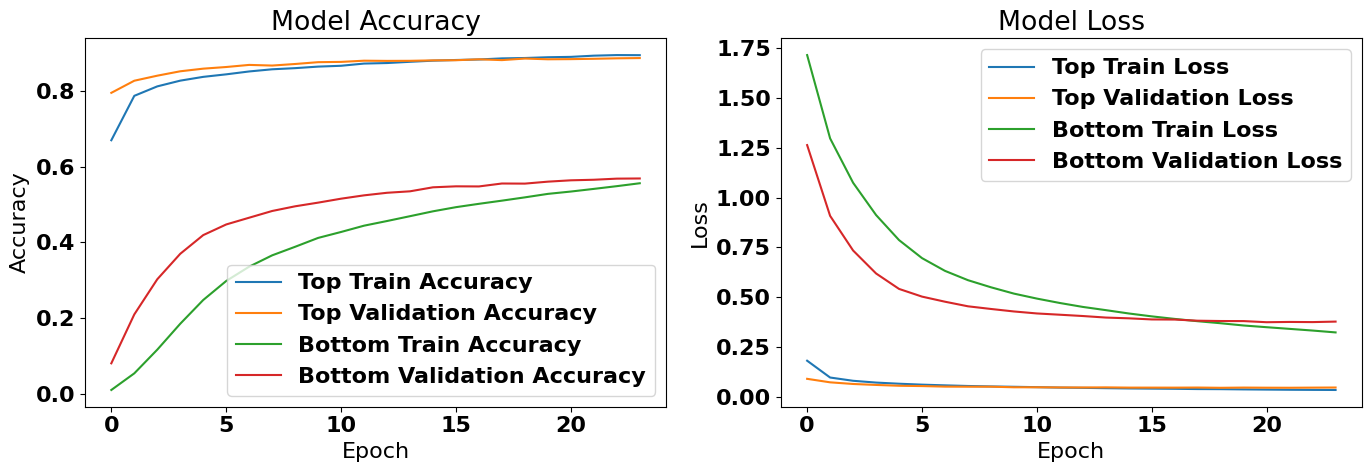

Evaluating model...
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
Top Category Macro F1 Score: 0.8713
Bottom Category Macro F1 Score: 0.5559

Top Category Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1837
           1       0.76      0.72      0.74      1306
           2       0.87      0.87      0.87       983
           3       0.86      0.90      0.88      1683
           4       0.91      0.88      0.89       934
           5       0.95      0.97      0.96      4455
           6       0.90      0.93      0.92      4972
           7       0.91      0.88      0.90      1113
           8       0.92      0.91      0.91      8131
           9       0.86      0.93      0.89      1169
          10       0.85      0.83      0.84      1820
          11       0.95      0.92      0.93       850
          12       0.95      0.98      0.96      1314
          13       0.84      0.89      0.86      2043
          14  

In [ ]:
# Build the BiLSTM model with GloVe embeddings and dual outputs

model = build_enhanced_rnn_model(
    len(tokenizer.word_index) + 1,  # vocabulary size
    max_len,
    embedding_dim,
    top_categories,
    bottom_categories,
    embedding_matrix,
)

# Print model summary
model.summary()

# Train the model
trained_model, history = train_model(
    model,
    X_train_padded,
    y_train_top,
    y_train_bottom,
    X_val_padded,
    y_val_top,
    y_val_bottom,
    batch_size=128,
    epochs=25
)

# Visualize training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['top_category_accuracy'], label='Top Train Accuracy')
plt.plot(history.history['val_top_category_accuracy'], label='Top Validation Accuracy')
plt.plot(history.history['bottom_category_accuracy'], label='Bottom Train Accuracy')
plt.plot(history.history['val_bottom_category_accuracy'], label='Bottom Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['top_category_loss'], label='Top Train Loss')
plt.plot(history.history['val_top_category_loss'], label='Top Validation Loss')
plt.plot(history.history['bottom_category_loss'], label='Bottom Train Loss')
plt.plot(history.history['val_bottom_category_loss'], label='Bottom Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluate the model
top_f1, bottom_f1 = evaluate_model(
    trained_model,
    X_test_padded,
    y_test_top,
    y_test_bottom,
    top_encoder,
    bottom_encoder
)

print(f"\nFinal Results:")
print(f"Top Category Macro F1 Score: {top_f1:.4f}")
print(f"Bottom Category Macro F1 Score: {bottom_f1:.4f}")

# Predticting on Unseen Test data

In [ ]:
# Required columns for training
required_columns = [
    'product_id', 'title', 'description', 'tags', 'type', 'room',
    'craft_type', 'recipient', 'material', 'occasion', 'holiday',
    'art_subject', 'style', 'shape', 'pattern'
]

# Define which columns are textual and which are metadata
text_columns = ['title', 'description', 'tags']
metadata_columns = [
    'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday',
    'art_subject', 'style', 'shape', 'pattern'
]

# Combined feature columns
feature_columns = text_columns + metadata_columns

# Set tokenization and embedding parameters
max_words = 50000
max_len = 300
embedding_dim = 200  # GloVe dimension

test_df = read_data("test", parquet_filenames_test)


test_df = test_df[required_columns].copy()

# Step 2: Preprocess text and metadata
unseen_data = preprocess_data(test_df, feature_columns, text_columns, metadata_columns,dataset_type='test')
X_unseen_text = unseen_data['combined_text']

# Step 3: Tokenize and pad using the same tokenizer
X_unseen_padded = pad_sequences(
    tokenizer.texts_to_sequences(X_unseen_text),
    maxlen=max_len,
    padding='post'
)

# Step 4: Predict top and bottom categories
preds = trained_model.predict(X_unseen_padded, verbose=1)
top_preds = preds[0].argmax(axis=1)
bottom_preds = preds[1].argmax(axis=1)

# Step 5: Decode predictions back to category labels
test_df['predicted_top_category'] = top_encoder.inverse_transform(top_preds)
test_df['predicted_bottom_category'] = bottom_encoder.inverse_transform(bottom_preds)

# Step 6: Save to parquet
test_df.to_parquet(
    "/content/drive/MyDrive/00. Etsy Machine Learning Challenge/Data/Predictions/predictions_14677.parquet", index=False
)

print("Predictions saved to 'predictions_14677.parquet'")


Preparing features...

 Ignoring duplicate values in test
798/798 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
Predictions saved to 'predictions_14677.parquet'


In [ ]:
test_df

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,predicted_top_category,predicted_bottom_category
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",physical,NaN,kids' crafts,NaN,NaN,NaN,valentine's day,NaN,NaN,NaN,NaN,craft_supplies_and_tools,craft_supplies_and_tools.pens_pencils_and_mark...
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",physical,NaN,drawing & drafting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,craft_supplies_and_tools,craft_supplies_and_tools.pens_pencils_and_mark...
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",physical,NaN,drawing & drafting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,craft_supplies_and_tools,craft_supplies_and_tools.pens_pencils_and_mark...
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",physical,NaN,drawing & drafting,NaN,NaN,birthday,valentine's day,NaN,NaN,NaN,NaN,craft_supplies_and_tools,craft_supplies_and_tools.pens_pencils_and_mark...
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",physical,NaN,calligraphy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,craft_supplies_and_tools,craft_supplies_and_tools.pens_pencils_and_mark...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25509,869022010,Dinosaur Rice Krispies Treats 0.78oz Wrapper P...,CUSTOM ITEM\n\nRice Krispies Treats Wrapper 0....,"Jurassic party,Jurassic Birthday,Jurassic invi...",download,NaN,NaN,NaN,NaN,birthday,NaN,NaN,fantasy,NaN,NaN,paper_and_party_supplies,paper_and_party_supplies.paper.gift_wrapping.c...
25510,954065860,"Strawberry Printable Candy Bar Wrapper, Snack ...",Customized Printables for all Occassions\n\nMa...,"tutti fruti chip bag,twotti frutti chips,tutti...",download,NaN,NaN,NaN,NaN,birthday,NaN,NaN,fantasia,NaN,NaN,paper_and_party_supplies,paper_and_party_supplies.party_supplies.party_...
25511,1417634130,Boy Birthday Party Thank You Candy Bar Wrapper...,☆ MATCHING ITEMS ☆\n3.5x2.5&quot; rectangle fa...,"thank you hershey,thank you candy bar,thank yo...",download,NaN,NaN,NaN,NaN,birthday,NaN,NaN,NaN,NaN,NaN,paper_and_party_supplies,paper_and_party_supplies.paper.gift_wrapping.c...
25512,942614980,Circus Candy bar 1.55oz PRINTABLE Treats Circu...,Customized Printables for all Occassions\n\nCa...,"potatoes wrapper,Circus favor,Printable Chip b...",download,NaN,NaN,NaN,NaN,birthday,NaN,NaN,fantasia,NaN,NaN,paper_and_party_supplies,paper_and_party_supplies.paper.gift_wrapping.c...
